# Notebook to process variants and their read count across conditions

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [2]:
### Input
rcdf_path = snakemake.input[0]

### Output
# Dataframes
selcoeffs_df_path = snakemake.output.selcoeffs
# Plots
hist_plot = snakemake.output.hist_plot
upset_plot = snakemake.output.upset_plot
rc_var_plot = snakemake.output.rc_var_plot
timepoints_plot = snakemake.output.timepoints_plot
scoeff_violin_plot = snakemake.output.scoeff_violin_plot
s_through_time_plot = snakemake.output.s_through_time_plot
replicates_plot = snakemake.output.replicates_plot

## Specify parameters

In [3]:
# Columns in the sequence layout (dataframes of expected variants) related to mutations (should be invariable from one project to another)
mutation_attributes = ['pos','alt_codons','alt_aa','aa_pos','nt_seq','aa_seq','Nham_nt','Nham_aa','Nham_codons']

# Project-specific columns in the sample layout
sample_attributes = snakemake.params.sample_attributes

# Project-specific target for the read count per variant
exp_rc_per_var = snakemake.params.exp_rc_per_var

# Project-specific threshold to label variants with a confidence score
rc_threshold = snakemake.params.rc_threshold

# Projet-specific file containing the number of mitotic generations for each condition
nbgen_path = snakemake.params.nb_gen

## Import data

In [4]:
covered_df = pd.read_csv(rcdf_path, index_col=0, dtype={'WT': 'boolean', # Boolean type supports missing data
                                                             'pos':str, 'aa_pos':str}) # pos and aa_pos contain mixed types because of the nucleotide WT - very important when pivoting later on
covered_df

,Sample_name,Pos_start,Pos_stop,Mutated_seq,Species,Mating_type,Replicate,Fragment,Timepoint,nt_seq,...,pos,aa_pos,alt_codons,alt_aa,aa_seq,Nham_codons,Nham_nt,Nham_aa,readcount,Location
0,CN_a_r1_F1_T0,2.0,71.0,CN_F1,CN,a,r1,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,107428.0,both
1,CN_a_r2_F1_T0,2.0,71.0,CN_F1,CN,a,r2,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,100432.0,both
2,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,97993.0,both
3,CN_alp_r2_F1_T0,2.0,71.0,CN_F1,CN,alp,r2,F1,T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,179995.0,both
4,CN_a_r1_F1_T1,2.0,71.0,CN_F1,CN,a,r1,F1,T1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,non-applicable,non-applicable,non-applicable,non-applicable,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,0.0,51819.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420410,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,AAC,N,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,2.0,1.0,6.0,both
420413,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,GAT,D,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,8.0,both
420414,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,GAC,D,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,552.0,both
420418,SC_alp_r2_F3_T3,92.0,158.0,SC_F3,SC,alp,r2,F3,T3,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,...,66,158,TGA,*,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,2.0,1.0,51.0,both


## Add rows corresponding to variants not present in all replicates/timepoints

In [5]:
covered_df['TR'] = covered_df['Timepoint'] + '_' + covered_df['Replicate']
conditions = covered_df.TR.unique()
T0_conditions = [x for x in conditions if 'T0' in x]

In [6]:
upset = covered_df.pivot_table(index = sample_attributes + mutation_attributes,
                               columns='TR', values='readcount',
                               fill_value=0
                              ).reset_index(level=mutation_attributes)
upset

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1    T0_r2  \
Species Mating_type Fragment                                                    
CN      a   

## Filter low read count variants

In [7]:
def get_confidence_score(g, threshold):
    if (g >= threshold).all(): # Above threshold in all replicates
        return 1 # best confidence score
    elif (g >= threshold).any(): # Above threshold in at least 1 replicate
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [8]:
upset['confidence_score'] = upset[T0_conditions].apply(lambda row: get_confidence_score(row, rc_threshold), axis=1)
mutation_attributes += ['confidence_score']
upset

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1    T0_r2  \
Species Mating_type Fragment                                                    
CN      a   

In [9]:
upset.reset_index().groupby(sample_attributes+['confidence_score'])[['nt_seq']].nunique()

TR                                             nt_seq
Species Mating_type Fragment confidence_score        
CN      a           F1       1                   4231
                             2                     31
                             3                     58
                    F2       1                   4210
                             2                     31
                             3                    101
                    F3       1                   3998
                             2                     38
                             3                    183
        alp         F1       1                   4157
                             2                     49
                             3                     96
                    F2       1                   4079
                             2                     52
                             3                    169
                    F3       1                   3953
                             2                     30
                             3                    219
SC      a           F1       1                   4055
                             2                     14
                             3                     60
                    F2       1                   4199
                             2                     45
                             3                     81
                    F3       1                   4114
                             2                     15
                             3                     39
        alp         F1       1                   3794
                             2                     29
                             3                    149
                    F2       1                   3947
                             2                     40
                             3                    170
                    F3       1                   3808
                             2                     28
                             3                    128

## Calculate frequencies

1. Variants with the lowest confidence score all filtered out
2. Read counts are normalized with the read depth for each sample
3. 1 is added to all counts and the frequency is log10-transformed

In [10]:
freq = upset.copy()
freq_conditions = [f'{x}_freq' for x in conditions]
T0_freq = [x for x in freq_conditions if 'T0' in x]

In [11]:
freq[freq_conditions] = freq[conditions].add(1) / freq.groupby(sample_attributes)[conditions].sum()
freq

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1  ...  \
Species Mating_type Fragment                                          ...   
CN      a           

In [12]:
# Retrieve overall mean frequency corresponding to the expected read count per variant
mean_exp_freq = (np.log10((exp_rc_per_var+1) / freq.groupby(sample_attributes)[conditions].sum())).mean(axis=None)

## Plot example of distribution of raw read count (per variant)

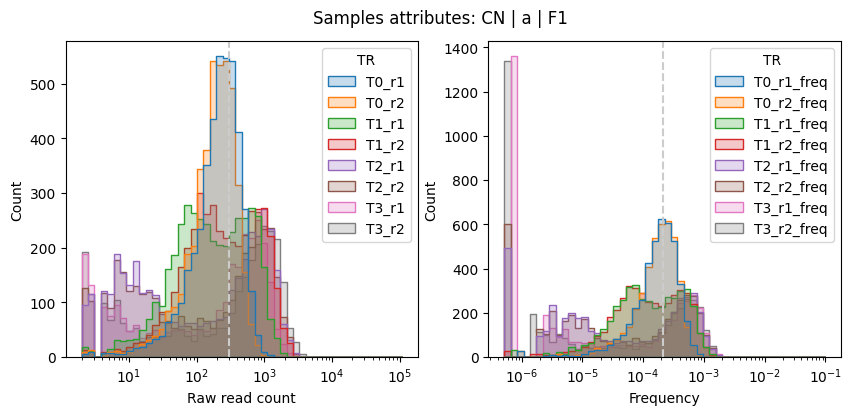

In [13]:
dataset1 = freq.index[0] # Just plotting for the first combination of sample attributes
graph1df = freq[conditions].loc[dataset1]
graph2df = freq[freq_conditions].loc[dataset1]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.histplot(graph1df, element='step', bins=50, common_norm=False, log_scale=10, ax=ax1)
ax1.axvline(x=exp_rc_per_var, linestyle='--', color='.8')
ax1.set(xlabel='Raw read count')

sns.histplot(graph2df, element='step', bins=50, log_scale=10, common_norm=False, ax=ax2)
ax2.axvline(x=10**mean_exp_freq, linestyle='--', color='.8')
ax2.set(xlabel='Frequency')

plt.subplots_adjust(top=.9)
plt.suptitle(f'Samples attributes: {" | ".join(dataset1)}')
plt.savefig(hist_plot, format='svg', dpi=300)

## Plot overlap across timepoints and replicates

In [14]:
freq['mean_input'] = freq[T0_freq].mean(axis=1)
bool_conditions = [f'{x}_indicator' for x in conditions]
freq[bool_conditions] = freq[conditions].astype(bool)
freq

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
SC      alp         F3                     9             TTA               L   
                    F3                     9             TTC               F   
                    F3                     9             TTG               L   
                    F3                     9             TTT               F   
                    F3        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
SC      alp         F3                   101   
                    F3                   101   
                    F3                   101   
                    F3                   101   
                    F3        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
SC      alp         F3        GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...   
                    F3        GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
SC      alp         F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   
                    F3        DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...   

TR                            Nham_nt  Nham_aa  Nham_codons    T0_r1  ...  \
Species Mating_type Fragment                                          ...   
CN      a           

In [15]:
upset_sub = freq.loc[dataset1] # Can be replaced with any specific combination of sample attributes
upset_sub

TR                                       pos      alt_codons          alt_aa  \
Species Mating_type Fragment                                                   
CN      a           F1                     0             AAA               K   
                    F1                     0             AAG               K   
                    F1                     0             AAT               N   
                    F1                     0             ACA               T   
                    F1                     0             ACC               T   
...                                      ...             ...             ...   
                    F1                     9             TTA               L   
                    F1                     9             TTC               F   
                    F1                     9             TTG               L   
                    F1                     9             TTT               F   
                    F1        non-applicable  non-applicable  non-applicable   

TR                                    aa_pos  \
Species Mating_type Fragment                   
CN      a           F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
                    F1                     2   
...                                      ...   
                    F1                    11   
                    F1                    11   
                    F1                    11   
                    F1                    11   
                    F1        non-applicable   

TR                                                                       nt_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
                    F1        ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   
...                                                                         ...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTAGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTCGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTGGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGTTTGAAGATTACCCACACT...   
                    F1        TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...   

TR                                                                       aa_seq  \
Species Mating_type Fragment                                                      
CN      a           F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
...                                                                         ...   
                    F1        SPVEGSPAKLEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKFEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKLEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKFEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   
                    F1        SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...   

TR                            Nham_nt  Nham_aa  Nham_codons     T0_r1  ...  \
Species Mating_type Fragment                                           ...   
CN      a         

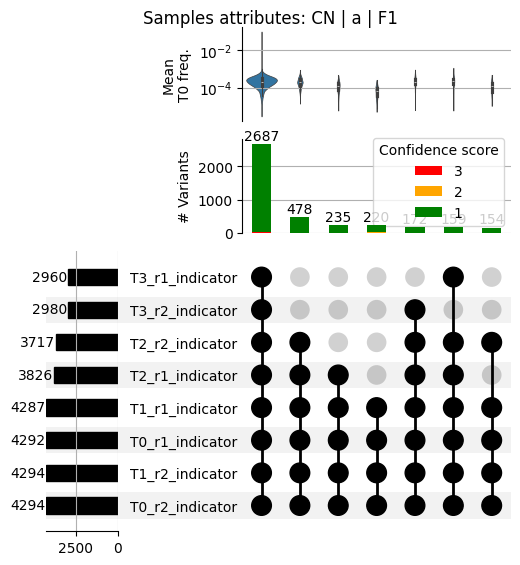

In [16]:
cscores = [1,2,3]
cscore_colors = ['green','orange','red']

fig = plt.figure(figsize=(6, 6))
upset_obj = UpSet(from_indicators(bool_conditions, data=upset_sub),
                   #show_percentages=True,
                   show_counts=True,
                   min_subset_size="1%",
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=0, # height of intersection barplot in matrix elements
                   totals_plot_elements = 2 # width of totals barplot in matrix elements
                  )

upset_obj.add_stacked_bars(by='confidence_score',
                           colors=dict(zip(cscores, cscore_colors)),
                           elements=3
                          )

upset_obj.add_catplot(value='mean_input', kind='violin', cut=0, density_norm='count',
                      log_scale=10, linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()
ax0 = d['extra0'] # Key corresponding to 1st stacked barplot - confidence score ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to 1st catplot - read count for input samples

ax0.set_ylabel('# Variants')
ax0.legend(title='Confidence score')

ax1.set_ylabel('Mean\nT0 freq.')

plt.subplots_adjust(top=.95)
plt.suptitle(f'Samples attributes: {" | ".join(dataset1)}')
plt.savefig(upset_plot, format='svg', dpi=300)

## Distribution of allele frequencies

In [17]:
longfreq = freq.melt(id_vars=mutation_attributes,
                     value_vars=freq_conditions, var_name='TR_freq',
                     value_name='frequency', ignore_index=False
                    ).reset_index()
longfreq

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,Nham_aa,Nham_codons,confidence_score,TR_freq,frequency
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,2.278410e-04
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,1.719395e-04
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,4.150263e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403195,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,8.431845e-07
403196,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,1,T3_r2_freq,2.810615e-07
403197,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,2.810615e-07
403198,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,1.292883e-05


In [18]:
longfreq['Timepoint'] = longfreq.TR_freq.apply(lambda x: x.split('_')[0])
longfreq['Replicate'] = longfreq.TR_freq.apply(lambda x: x.split('_')[1])
longfreq

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,Nham_aa,Nham_codons,confidence_score,TR_freq,frequency,Timepoint,Replicate
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05,T0,r1
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,1.439887e-05,T0,r1
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,2.278410e-04,T0,r1
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,1.719395e-04,T0,r1
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,4.150263e-05,T0,r1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403195,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,8.431845e-07,T3,r2
403196,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,1.0,1,T3_r2_freq,2.810615e-07,T3,r2
403197,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,2.810615e-07,T3,r2
403198,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,1.0,1,T3_r2_freq,1.292883e-05,T3,r2


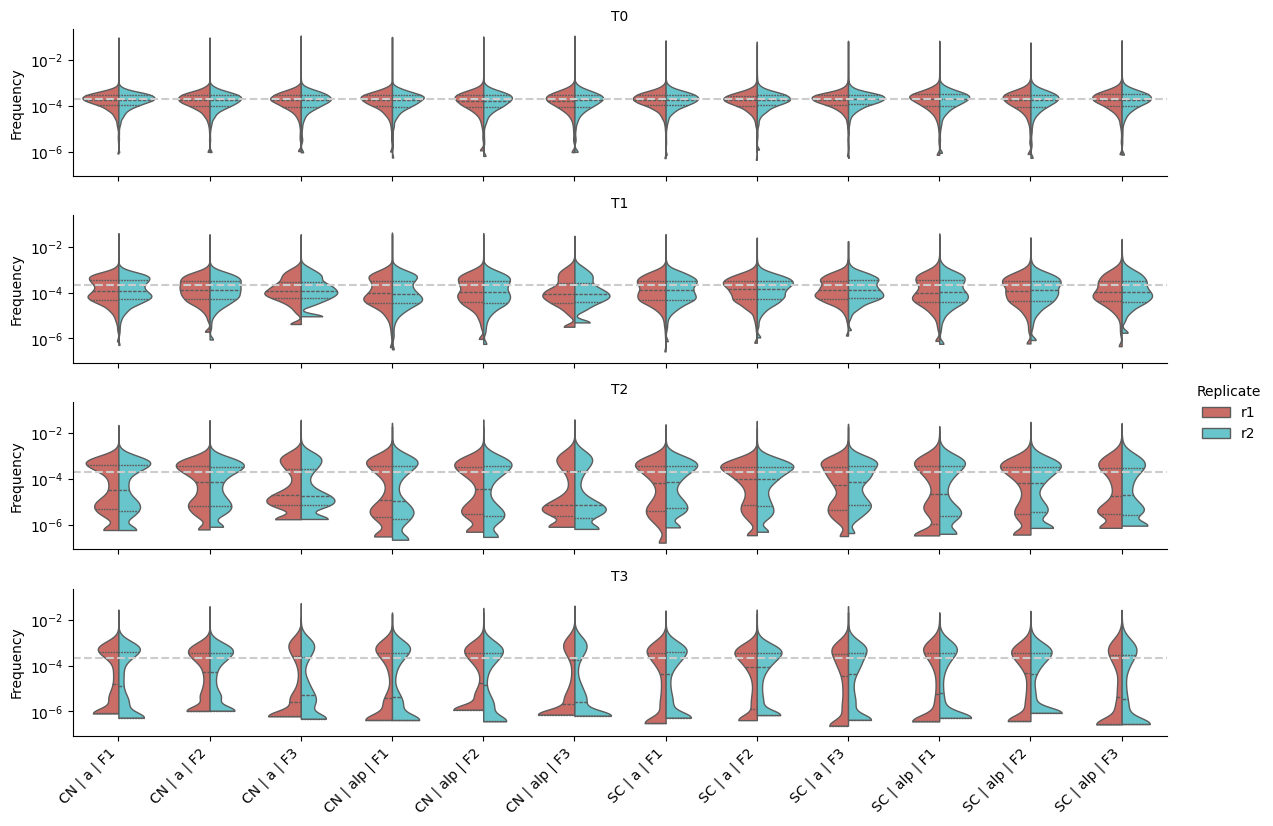

In [19]:
graphdf = longfreq.copy()
graphdf['Sample attributes'] = graphdf[sample_attributes].agg(' | '.join, axis=1)
labels = graphdf['Sample attributes'].unique()
g = sns.catplot(graphdf, x='Sample attributes', y='frequency', row='Timepoint',
            hue='Replicate', palette='hls', split=True,
            log_scale=10,
            kind='violin', cut=0, linewidth=1, inner='quart',
            height=2, aspect=.5*len(labels)
           )
g.map(plt.axhline, y=10**mean_exp_freq, linestyle='--', color='.8')

g.set_axis_labels('','Frequency')
g.set_titles(row_template='{row_name}')
g.set_xticklabels(labels, rotation=45, ha='right')
plt.savefig(rc_var_plot, format='svg', dpi=300)

## Get mutation type

In [20]:
def get_mutation_type(Nham_aa, alt_aa):
    # Quick function to determine if the mutation is synonymous or non-synonymous<
    # and if it's missense or nonsense
    if Nham_aa == 0:
        return 'synonymous'
    elif alt_aa == '*':
        return 'nonsense'
    else:
        return 'missense'

In [21]:
longfreq['mutation_type'] = longfreq.apply(lambda row: get_mutation_type(row.Nham_aa, row.alt_aa), axis=1)
mutation_attributes += ['mutation_type']
longfreq.head(4)

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,Nham_aa,Nham_codons,confidence_score,TR_freq,frequency,Timepoint,Replicate,mutation_type
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,0.000014,T0,r1,missense
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,1.0,1.0,1,T0_r1_freq,0.000014,T0,r1,missense
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,0.000228,T0,r1,missense
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,1.0,1.0,1,T0_r1_freq,0.000172,T0,r1,missense


## Calculate Log2(fold-change) for every timepoint relative to T0

In [22]:
freq_wide = longfreq.pivot(index=sample_attributes+mutation_attributes+['Replicate'],
                              columns='Timepoint',
                              values='frequency')
freq_wide

Timepoint                                                                                                                                                                                                                                                                  T0  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                                             Nham_nt Nham_aa Nham_codons confidence_score mutation_type Replicate             
CN      a           F1       0              AAA            K              2              AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000013   
                                            AAG            K              2              AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000035   
                                            AAT            N              2              AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 2.0     1.0     1.0         1                missense      r1         0.000228   
...                                                                                                                                                                                                                                                                       ...   
SC      alp         F3       9              TTG            L              101            GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTGT... DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r2         0.000328   
                                            TTT            F              101            GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTGT... DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r1         0.000241   
                                                                                                                                                                                                                                                          r2         0.000240   
                             non-applicable non-applicable non-applicable non-applicable GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGT... DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 0.0     0.0     0.0         1                synonymous    r1         0.068868   
                                                                                                                                                                                                                                                          r2         0.073995   

Timepoint                                                                                                                                                                                                                                                                  T1  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                               

In [23]:
timepoints = [x for x in freq_wide.columns]
lfc_combinations = [(x,'T0') for x in timepoints[1:]]
lfc_combinations
lfc_cols = [f'Lfc_{"_".join(x)}' for x in lfc_combinations]
lfc_cols

['Lfc_T1_T0', 'Lfc_T2_T0', 'Lfc_T3_T0']

In [24]:
for i,v in enumerate(lfc_cols):
    freq_wide[v] = freq_wide.apply(lambda row: np.log2(row[lfc_combinations[i][0]] / row[lfc_combinations[i][1]]), axis=1)

freq_wide

Timepoint                                                                                                                                                                                                                                                                  T0  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                                             Nham_nt Nham_aa Nham_codons confidence_score mutation_type Replicate             
CN      a           F1       0              AAA            K              2              AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000013   
                                            AAG            K              2              AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 3.0     1.0     1.0         1                missense      r1         0.000014   
                                                                                                                                                                                                                                                          r2         0.000035   
                                            AAT            N              2              AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACTT... NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSRI... 2.0     1.0     1.0         1                missense      r1         0.000228   
...                                                                                                                                                                                                                                                                       ...   
SC      alp         F3       9              TTG            L              101            GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTGT... DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r2         0.000328   
                                            TTT            F              101            GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTGT... DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 2.0     1.0     1.0         1                missense      r1         0.000241   
                                                                                                                                                                                                                                                          r2         0.000240   
                             non-applicable non-applicable non-applicable non-applicable GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGT... DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERCK... 0.0     0.0     0.0         1                synonymous    r1         0.068868   
                                                                                                                                                                                                                                                          r2         0.073995   

Timepoint                                                                                                                                                                                                                                                                  T1  \
Species Mating_type Fragment pos            alt_codons     alt_aa         aa_pos         nt_seq                                             aa_seq                               

## Normalize with number of mitotic generations

In [25]:
nbgen_df = pd.read_excel(nbgen_path)
nbgen_wide = nbgen_df.pivot(index=sample_attributes+['Replicate'],
                            columns='Timepoint',
                            values='Nb_gen'
                           )
nbgen_wide.columns = [f'{x}_gen' for x in nbgen_wide.columns]
for i,x in enumerate(timepoints):
    if i in [0,1]:
        pass
    else:
        nbgen_wide[f'cumul_{x}_gen'] = nbgen_wide[[f'{t}_gen' for t in timepoints[1:i]+[x]]].sum(axis=1)
for x in nbgen_wide.columns:
    if 'cumul_' in x:
        nbgen_wide[x.split('cumul_')[1]] = nbgen_wide[x]
        nbgen_wide.drop(x, axis=1, inplace=True)
nbgen_wide

T1_gen     T2_gen     T3_gen
Species Mating_type Fragment Replicate                                
CN      a           F1       r1         4.868106  10.121358  15.497015
                             r2         4.779851   9.884670  15.235865
                    F2       r1         4.930749  10.207785  15.612646
                             r2         4.967964  10.166635  15.495678
                    F3       r1         4.898172  10.073597  15.360543
                             r2         4.913619   9.981624  15.215541
        alp         F1       r1         5.043224  10.374374  15.909579
                             r2         5.043355  10.405141  15.803620
                    F2       r1         5.135997  10.540576  16.017792
                             r2         5.119450  10.511337  15.929148
                    F3       r1         4.983051  10.329103  15.717043
                             r2         4.991102  10.343490  15.785463
SC      a           F1       r1         4.945900  10.227098  15.518766
                             r2         5.028227  10.210144  15.468691
                    F2       r1         4.937921  10.075896  15.353611
                             r2         5.052079  10.256317  15.503058
                    F3       r1         4.807419  10.000698  15.374999
                             r2         4.935000   9.954813  15.275866
        alp         F1       r1         5.082713  10.372013  15.845110
                             r2         5.057634  10.389966  15.824119
                    F2       r1         5.143444  10.541025  15.948301
                             r2         5.071945  10.400440  15.856220
                    F3       r1         4.958483  10.254702  15.632164
                             r2         5.000597  10.316290  15.766767

In [26]:
lfc_wide = freq_wide.reset_index().merge(right=nbgen_wide.reset_index(), on=sample_attributes+['Replicate'])
gen_cols = nbgen_wide.columns
lfc_wide[gen_cols]

,T1_gen,T2_gen,T3_gen
0,4.868106,10.121358,15.497015
1,4.868106,10.121358,15.497015
2,4.868106,10.121358,15.497015
3,4.868106,10.121358,15.497015
4,4.868106,10.121358,15.497015
...,...,...,...
100795,5.000597,10.316290,15.766767
100796,5.000597,10.316290,15.766767
100797,5.000597,10.316290,15.766767
100798,5.000597,10.316290,15.766767


In [27]:
for x in list(zip(lfc_cols, gen_cols)):
    lfc_wide[x[0]] /= lfc_wide[x[1]]
lfc_wide

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,...,T0,T1,T2,T3,Lfc_T1_T0,Lfc_T2_T0,Lfc_T3_T0,T1_gen,T2_gen,T3_gen
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,0.000014,0.000006,2.399285e-06,8.161879e-07,-0.262676,-0.255428,-0.267207,4.868106,10.121358,15.497015
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,0.000014,0.000005,5.998214e-07,8.161879e-07,-0.302249,-0.453030,-0.267207,4.868106,10.121358,15.497015
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,0.000228,0.000059,4.198750e-06,8.161879e-07,-0.398678,-0.569284,-0.524289,4.868106,10.121358,15.497015
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,0.000172,0.000039,7.197856e-06,8.161879e-07,-0.442917,-0.452330,-0.498082,4.868106,10.121358,15.497015
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,0.000042,0.000008,5.998214e-07,3.264752e-06,-0.482025,-0.603924,-0.236701,4.868106,10.121358,15.497015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,0.000239,0.000088,5.557609e-06,8.431845e-07,-0.287861,-0.525939,-0.516674,5.000597,10.316290,15.766767
100796,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,...,0.000271,0.000060,9.262681e-07,2.810615e-07,-0.436043,-0.794404,-0.628908,5.000597,10.316290,15.766767
100797,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,0.000328,0.000085,7.410145e-06,2.810615e-07,-0.390763,-0.529878,-0.646101,5.000597,10.316290,15.766767
100798,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,0.000240,0.000076,1.945163e-05,1.292883e-05,-0.333200,-0.351629,-0.267449,5.000597,10.316290,15.766767


## Normalize with median of synonymous codons

In [28]:
syn = lfc_wide[(lfc_wide.Nham_nt >0) & (lfc_wide.Nham_aa == 0)][sample_attributes+['Replicate']+lfc_cols]
syn

,Species,Mating_type,Fragment,Replicate,Lfc_T1_T0,Lfc_T2_T0,Lfc_T3_T0
8,CN,a,F1,r1,-0.316431,-0.437879,-0.438466
10,CN,a,F1,r1,-0.357609,-0.466724,-0.419559
51,CN,a,F1,r1,-0.524912,-0.752543,-0.462824
52,CN,a,F1,r1,0.000282,-0.169958,-0.184603
53,CN,a,F1,r1,-0.435183,-0.668965,-0.510513
...,...,...,...,...,...,...,...
100542,SC,alp,F3,r2,-0.430620,-0.593733,-0.624457
100589,SC,alp,F3,r2,-0.494066,-0.717117,-0.678864
100629,SC,alp,F3,r2,-0.525023,-0.651660,-0.535510
100630,SC,alp,F3,r2,-0.527772,-0.741934,-0.594576


In [29]:
syn.describe()

,Lfc_T1_T0,Lfc_T2_T0,Lfc_T3_T0
count,3956.000000,3956.000000,3956.000000
mean,-0.394863,-0.526172,-0.416596
std,0.152665,0.194823,0.154930
min,-1.036720,-1.076014,-0.777878
25%,-0.475292,-0.642462,-0.526291
50%,-0.417243,-0.537494,-0.438135
75%,-0.340804,-0.432911,-0.334861
max,0.832081,0.356548,0.261942


In [30]:
mediansyn = syn.groupby(sample_attributes+['Replicate'])[lfc_cols].median()
mediansyn.columns = [x.replace('Lfc','med') for x in mediansyn.columns]
med_cols = mediansyn.columns
mediansyn

med_T1_T0  med_T2_T0  med_T3_T0
Species Mating_type Fragment Replicate                                 
CN      a           F1       r1         -0.390109  -0.529649  -0.431701
                             r2         -0.392597  -0.562409  -0.469425
                    F2       r1         -0.392695  -0.509285  -0.387017
                             r2         -0.398447  -0.505364  -0.384607
                    F3       r1         -0.297031  -0.429869  -0.431762
                             r2         -0.259288  -0.436037  -0.387290
        alp         F1       r1         -0.421764  -0.569321  -0.444777
                             r2         -0.431129  -0.562618  -0.435887
                    F2       r1         -0.441281  -0.548893  -0.377591
                             r2         -0.465792  -0.588155  -0.452389
                    F3       r1         -0.360898  -0.504762  -0.381681
                             r2         -0.328870  -0.520814  -0.368151
SC      a           F1       r1         -0.439247  -0.546193  -0.466990
                             r2         -0.423889  -0.517526  -0.482487
                    F2       r1         -0.459810  -0.553364  -0.496487
                             r2         -0.457969  -0.567374  -0.463098
                    F3       r1         -0.396230  -0.547284  -0.446787
                             r2         -0.372103  -0.493825  -0.470996
        alp         F1       r1         -0.461047  -0.612187  -0.484372
                             r2         -0.434681  -0.578651  -0.490859
                    F2       r1         -0.466554  -0.574308  -0.480159
                             r2         -0.458203  -0.558818  -0.446420
                    F3       r1         -0.431572  -0.581306  -0.486261
                             r2         -0.430844  -0.542025  -0.478274

## Calculate selection coefficients

In [31]:
selcoeff_cols = [x.replace('Lfc','s') for x in lfc_cols]
s_wide = lfc_wide.merge(right=mediansyn.reset_index(), on=sample_attributes+['Replicate'])

In [32]:
for i,s in enumerate(selcoeff_cols):
    s_wide[s] = s_wide[lfc_cols[i]] - s_wide[med_cols[i]]
s_wide

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,...,Lfc_T3_T0,T1_gen,T2_gen,T3_gen,med_T1_T0,med_T2_T0,med_T3_T0,s_T1_T0,s_T2_T0,s_T3_T0
0,CN,a,F1,0,AAA,K,2,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,-0.267207,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.127433,0.274221,0.164494
1,CN,a,F1,0,AAG,K,2,AAGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,3.0,...,-0.267207,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.087860,0.076619,0.164494
2,CN,a,F1,0,AAT,N,2,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,-0.524289,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,-0.008569,-0.039635,-0.092588
3,CN,a,F1,0,ACA,T,2,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,-0.498082,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,-0.052808,0.077319,-0.066381
4,CN,a,F1,0,ACC,T,2,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,2.0,...,-0.236701,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,-0.091916,-0.074275,0.195000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,SC,alp,F3,9,TTA,L,101,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,-0.516674,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,0.142983,0.016086,-0.038400
100796,SC,alp,F3,9,TTC,F,101,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,...,-0.628908,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.005200,-0.252380,-0.150634
100797,SC,alp,F3,9,TTG,L,101,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,-0.646101,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,0.040081,0.012146,-0.167827
100798,SC,alp,F3,9,TTT,F,101,GACATGTGTACTGGTGCCATTATTATGTTTGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,...,-0.267449,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,0.097644,0.190395,0.210824


## Repeat WT at every position

### Repeat row for every position in the protein sequence

In [33]:
# Select WT nucleotide sequence(s)
WTdf = s_wide[s_wide.Nham_nt == 0]

# Get length of protein sequence
WTdf['len_aa'] = WTdf.aa_seq.apply(lambda x: len(x))

# Create list of positions for every sequence
WTdf['pos'] = WTdf.len_aa.apply(lambda x: np.arange(x))

# Same with WT codons (list of codons at every matching position)
WTdf['alt_codons'] = WTdf.nt_seq.apply(lambda x: [x[i:i+3] for i in range(0, len(x), 3)])

# Same with WT amino acid
WTdf['alt_aa'] = WTdf.aa_seq.apply(lambda x: [y for y in x])

# Then we use explode to turn horizontal lists into rows with matching values for all 3 columns
WTdf = WTdf.explode(['pos','alt_codons','alt_aa'])
WTdf

C:\Users\duran\AppData\Local\Temp\ipykernel_9948\1415475194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WTdf['len_aa'] = WTdf.aa_seq.apply(lambda x: len(x))
C:\Users\duran\AppData\Local\Temp\ipykernel_9948\1415475194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WTdf['pos'] = WTdf.len_aa.apply(lambda x: np.arange(x))
C:\Users\duran\AppData\Local\Temp\ipykernel_9948\1415475194.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,aa_pos,nt_seq,aa_seq,Nham_nt,...,T1_gen,T2_gen,T3_gen,med_T1_T0,med_T2_T0,med_T3_T0,s_T1_T0,s_T2_T0,s_T3_T0,len_aa
4319,CN,a,F1,0,TCT,S,non-applicable,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,...,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70
4319,CN,a,F1,1,CCT,P,non-applicable,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,...,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70
4319,CN,a,F1,2,GTT,V,non-applicable,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,...,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70
4319,CN,a,F1,3,GAA,E,non-applicable,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,...,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70
4319,CN,a,F1,4,GGT,G,non-applicable,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,...,4.868106,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100799,SC,alp,F3,62,GAA,E,non-applicable,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,...,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67
100799,SC,alp,F3,63,GAT,D,non-applicable,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,...,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67
100799,SC,alp,F3,64,ATT,I,non-applicable,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,...,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67
100799,SC,alp,F3,65,GGT,G,non-applicable,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,...,5.000597,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67


### Get non-WT

In [42]:
# In this step we need to cast the dtype of pos and aa_pos
# which we could not do before because the WT rows feature string values ("non-applicable")
nonWT = s_wide[s_wide.Nham_nt > 0]
nonWT[['pos','aa_pos']] = nonWT[['pos','aa_pos']].astype(int)

C:\Users\duran\AppData\Local\Temp\ipykernel_9948\2451737801.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonWT[['pos','aa_pos']] = nonWT[['pos','aa_pos']].astype(int)


### Retrieve position offset (position in the full protein sequence)

In [43]:
offpos = nonWT.groupby(sample_attributes)[['pos','aa_pos']].min()

if offpos.pos.sum() == 0:
    WTdf = pd.merge(left=WTdf.drop(columns='aa_pos'), right=offpos[['aa_pos']].reset_index(), on=sample_attributes)
else:
    print('There is at least one case where there is no sequenced mutant at position 0, which prevents from retrieving the start position in the full protein sequence (min aa_pos)')

WTdf['aa_pos'] += WTdf['pos']
WTdf

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,nt_seq,aa_seq,Nham_nt,Nham_aa,...,T2_gen,T3_gen,med_T1_T0,med_T2_T0,med_T3_T0,s_T1_T0,s_T2_T0,s_T3_T0,len_aa,aa_pos
0,CN,a,F1,0,TCT,S,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70,2
1,CN,a,F1,1,CCT,P,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70,3
2,CN,a,F1,2,GTT,V,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70,4
3,CN,a,F1,3,GAA,E,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70,5
4,CN,a,F1,4,GGT,G,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,SC,alp,F3,62,GAA,E,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,0.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67,154
1664,SC,alp,F3,63,GAT,D,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,0.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67,155
1665,SC,alp,F3,64,ATT,I,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,0.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67,156
1666,SC,alp,F3,65,GGT,G,GACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTG...,DMCTGAIIMYGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,0.0,0.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.026297,0.404420,0.384516,67,157


In [44]:
allpos_df = pd.concat([WTdf, nonWT], ignore_index=True)
allpos_df

,Species,Mating_type,Fragment,pos,alt_codons,alt_aa,nt_seq,aa_seq,Nham_nt,Nham_aa,...,T2_gen,T3_gen,med_T1_T0,med_T2_T0,med_T3_T0,s_T1_T0,s_T2_T0,s_T3_T0,len_aa,aa_pos
0,CN,a,F1,0,TCT,S,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70.0,2
1,CN,a,F1,1,CCT,P,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70.0,3
2,CN,a,F1,2,GTT,V,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70.0,4
3,CN,a,F1,3,GAA,E,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70.0,5
4,CN,a,F1,4,GGT,G,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,SPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.0,0.0,...,10.121358,15.497015,-0.390109,-0.529649,-0.431701,0.134758,0.306213,0.320445,70.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102439,SC,alp,F3,9,TGT,C,GACATGTGTACTGGTGCCATTATTATGTGTGGTATCCCAAGATGTG...,DMCTGAIIMCGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,0.047111,-0.015652,0.015036,NaN,101
102440,SC,alp,F3,9,TTA,L,GACATGTGTACTGGTGCCATTATTATGTTAGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,0.142983,0.016086,-0.038400,NaN,101
102441,SC,alp,F3,9,TTC,F,GACATGTGTACTGGTGCCATTATTATGTTCGGTATCCCAAGATGTG...,DMCTGAIIMFGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,1.0,1.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,-0.005200,-0.252380,-0.150634,NaN,101
102442,SC,alp,F3,9,TTG,L,GACATGTGTACTGGTGCCATTATTATGTTGGGTATCCCAAGATGTG...,DMCTGAIIMLGIPRCVVGENVNFKSKGEKYLQTRGHEVVVVDDERC...,2.0,1.0,...,10.316290,15.766767,-0.430844,-0.542025,-0.478274,0.040081,0.012146,-0.167827,NaN,101


## Calculate median selection coefficient (over synonymous mutants)

In [48]:
median_df = allpos_df.groupby(sample_attributes+['Replicate','aa_pos','alt_aa']
                          )[selcoeff_cols + ['confidence_score', 'Nham_aa', 'mutation_type']
                           ].agg(dict(zip(selcoeff_cols + ['confidence_score', 'Nham_aa', 'mutation_type'],
                                          ['median']*len(selcoeff_cols) + ['min', 'first', 'first']))
                                ).reset_index(level=['aa_pos','alt_aa'])
median_df

aa_pos alt_aa   s_T1_T0   s_T2_T0  \
Species Mating_type Fragment Replicate                                      
CN      a           F1       r1              2      *  0.554976  0.652621   
                             r1              2      A  0.068379  0.085874   
                             r1              2      C  0.036511  0.166990   
                             r1              2      D  0.150006  0.222158   
                             r1              2      E  0.216652  0.331802   
...                                        ...    ...       ...       ...   
SC      alp         F3       r2            158      S  0.040795 -0.057593   
                             r2            158      T  0.063049 -0.144815   
                             r2            158      V  0.013240 -0.018815   
                             r2            158      W  0.104037 -0.118050   
                             r2            158      Y  0.113993  0.030078   

                                         s_T3_T0  confidence_score  Nham_aa  \
Species Mating_type Fragment Replicate                                        
CN      a           F1       r1         0.511516                 1      1.0   
                             r1        -0.016831                 1      1.0   
                             r1         0.182096                 1      1.0   
                             r1         0.090227                 1      1.0   
                             r1         0.133517                 1      1.0   
...                                          ...               ...      ...   
SC      alp         F3       r2        -0.004272                 1      1.0   
                             r2        -0.080254                 1      1.0   
                             r2        -0.111499                 1      1.0   
                             r2        -0.062742                 1      1.0   
                             r2        -0.060957                 1      1.0   

                                       mutation_type  
Species Mating_type Fragment Replicate                
CN      a           F1       r1             nonsense  
                             r1             missense  
                             r1             missense  
                             r1             missense  
                             r1             missense  
...                                              ...  
SC      alp         F3       r2             missense  
                             r2             missense  
                             r2             missense  
                             r2             missense  
                             r2             missense  

[34876 rows x 8 columns]

In [49]:
median_df.to_csv(selcoeffs_df_path)

In [50]:
median_df.index[0]

('CN', 'a', 'F1', 'r1')

## Plot example of correlation between compared timepoints

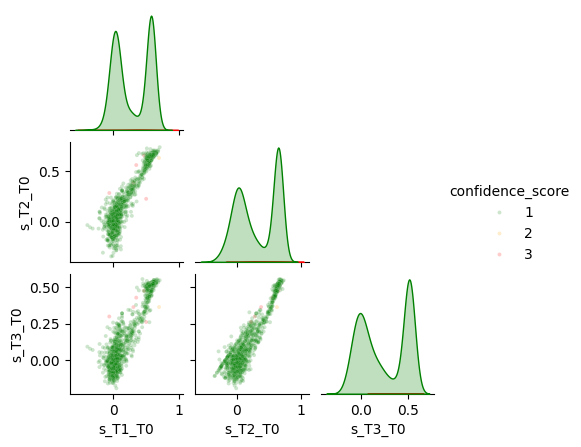

In [51]:
dataset1_r1 = median_df.index[0]
graphdf = median_df.loc[dataset1_r1].reset_index()
sns.pairplot(graphdf, vars=selcoeff_cols,
             hue='confidence_score', hue_order=cscores, palette=dict(zip(cscores, cscore_colors)),
             plot_kws={'s':8, 'alpha':.2},
             height=1.5, corner=True)
plt.savefig(timepoints_plot, format='svg', dpi=300)

## Plot overall distribution of selection coefficients

In [52]:
mutation_attributes_aa = ['aa_pos','alt_aa','Nham_aa','mutation_type']
median_long = median_df.melt(id_vars=mutation_attributes_aa,
                        value_vars=selcoeff_cols, var_name='Compared timepoints',
                        value_name='s', ignore_index=False).reset_index()
median_long

,Species,Mating_type,Fragment,Replicate,aa_pos,alt_aa,Nham_aa,mutation_type,Compared timepoints,s
0,CN,a,F1,r1,2,*,1.0,nonsense,s_T1_T0,0.554976
1,CN,a,F1,r1,2,A,1.0,missense,s_T1_T0,0.068379
2,CN,a,F1,r1,2,C,1.0,missense,s_T1_T0,0.036511
3,CN,a,F1,r1,2,D,1.0,missense,s_T1_T0,0.150006
4,CN,a,F1,r1,2,E,1.0,missense,s_T1_T0,0.216652
...,...,...,...,...,...,...,...,...,...,...
104623,SC,alp,F3,r2,158,S,1.0,missense,s_T3_T0,-0.004272
104624,SC,alp,F3,r2,158,T,1.0,missense,s_T3_T0,-0.080254
104625,SC,alp,F3,r2,158,V,1.0,missense,s_T3_T0,-0.111499
104626,SC,alp,F3,r2,158,W,1.0,missense,s_T3_T0,-0.062742


In [53]:
median_long['Sample attributes'] = median_long[sample_attributes].agg(' | '.join, axis=1)
labels = median_long['Sample attributes'].unique()
median_long['Compared timepoints'] = median_long['Compared timepoints'].apply(lambda x: x.split('_')[1])

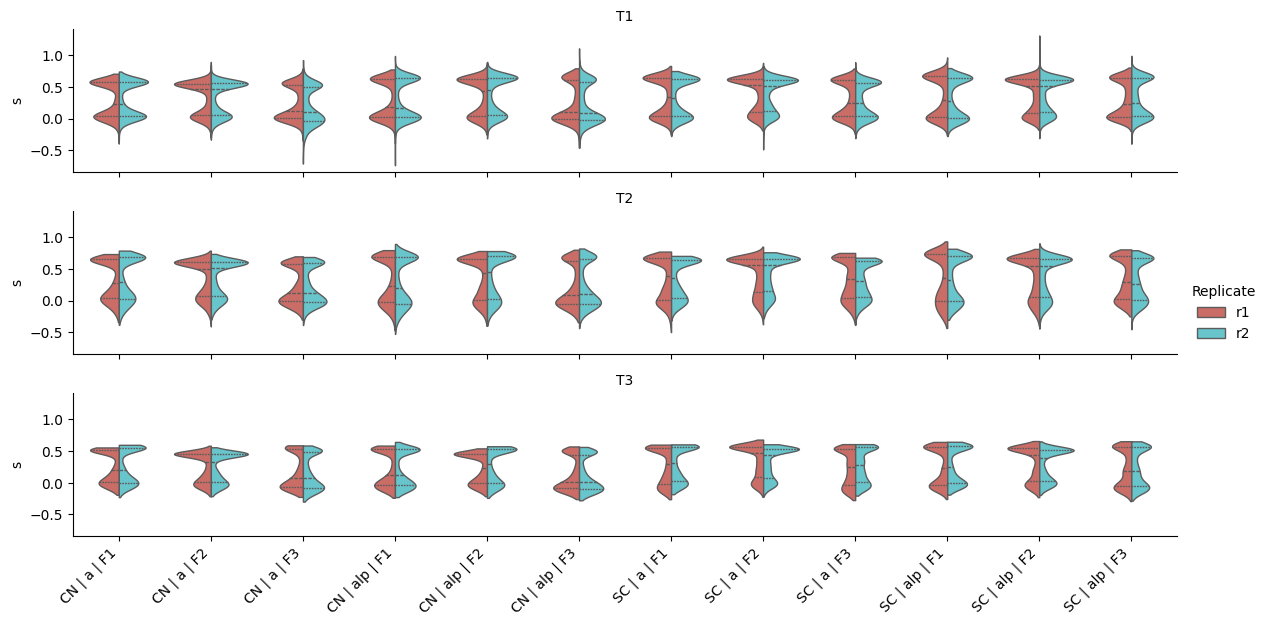

In [54]:
g = sns.catplot(median_long, x='Sample attributes', y='s',
                row='Compared timepoints', row_order=timepoints[1:],
                hue='Replicate', palette='hls', split=True,
                kind='violin', cut=0, linewidth=1, inner='quart',
                height=2, aspect=.5*len(labels)
               )

g.set_axis_labels('','s')
g.set_titles(row_template='{row_name}')
g.set_xticklabels(labels, rotation=45, ha='right')
plt.savefig(scoeff_violin_plot, format='svg', dpi=300)

## Plot selection through time

In [55]:
median_long.groupby(['Sample attributes','Replicate','mutation_type','Compared timepoints'])[['s']].describe()

s  \
                                                                count   
Sample attributes Replicate mutation_type Compared timepoints           
CN | a | F1       r1        missense      T1                   1327.0   
                                          T2                   1327.0   
                                          T3                   1327.0   
                            nonsense      T1                     70.0   
                                          T2                     70.0   
...                                                               ...   
SC | alp | F3     r2        nonsense      T2                     67.0   
                                          T3                     67.0   
                            synonymous    T1                     67.0   
                                          T2                     67.0   
                                          T3                     67.0   

                                                                         \
                                                                   mean   
Sample attributes Replicate mutation_type Compared timepoints             
CN | a | F1       r1        missense      T1                   0.286073   
                                          T2                   0.313731   
                                          T3                   0.236759   
                            nonsense      T1                   0.583095   
                                          T2                   0.654783   
...                                                                 ...   
SC | alp | F3     r2        nonsense      T2                   0.681662   
                                          T3                   0.573785   
                            synonymous    T1                   0.000972   
                                          T2                   0.170650   
                                          T3                   0.168526   

                                                                         \
                                                                    std   
Sample attributes Replicate mutation_type Compared timepoints             
CN | a | F1       r1        missense      T1                   0.268827   
                                          T2                   0.311590   
                                          T3                   0.247172   
                            nonsense      T1                   0.041202   
                                          T2                   0.020832   
...                                                                 ...   
SC | alp | F3     r2        nonsense      T2                   0.038949   
                                          T3                   0.046415   
                            synonymous    T1                   0.069549   
                                          T2                   0.154550   
                                          T3                   0.146287   

                                                                         \
                                                                    min   
Sample attributes Replicate mutation_type Compared timepoints             
CN | a | F1       r1        missense      T1                  -0.393720   
                                          T2                  -0.343081   
                                          T3                  -0.192763   
                            nonsense      T1                   0.391402   
                                          T2                   0.569597   
...                                                                 ...   
SC | alp | F3     r2        nonsense      T2                   0.395539   
                                          T3                   0.207158   
                            synonymous    T1                  -0.094179   
                                          T

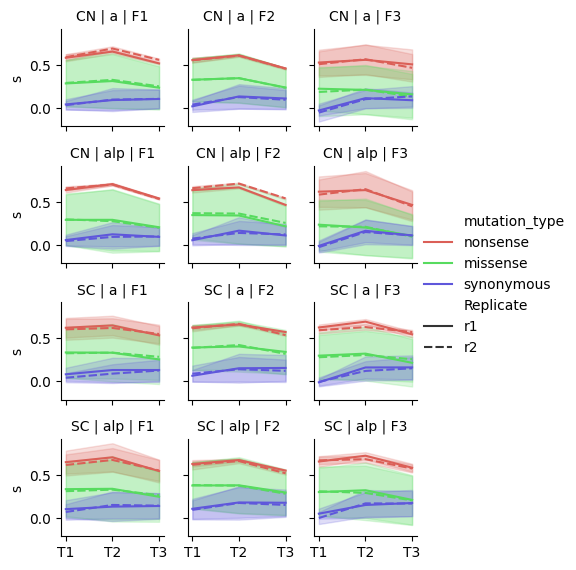

In [56]:
g = sns.relplot(data=median_long, x='Compared timepoints', y='s',
                col='Sample attributes', col_wrap=3,
                hue='mutation_type', palette='hls',
                style='Replicate',
                kind='line', errorbar='sd',
                height=1.5)
g.set(xlabel='')
g.set_titles(col_template='{col_name}')
plt.savefig(s_through_time_plot, format='svg', dpi=300)

## Show correlation between first two replicates

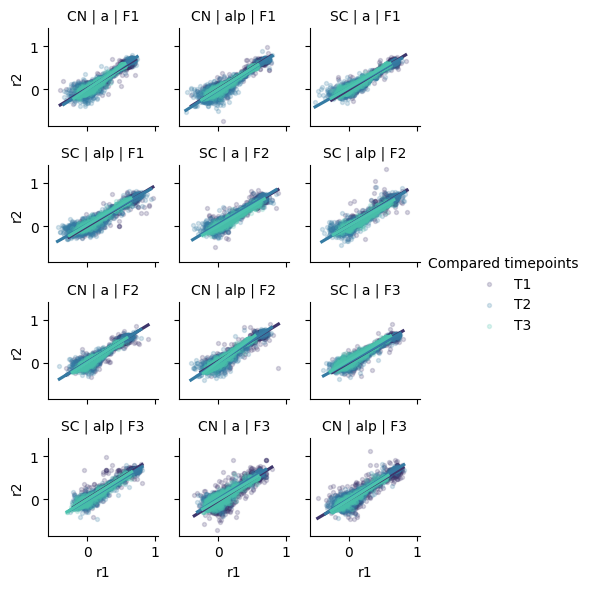

In [57]:
graphdf = median_long.pivot(index=mutation_attributes_aa+['Sample attributes','Compared timepoints'],
                            columns='Replicate',
                            values='s').reset_index()
firstTwoReplicates = median_long.Replicate.unique()[:2]

g = sns.lmplot(graphdf, x=firstTwoReplicates[0], y=firstTwoReplicates[1],
               col='Sample attributes', col_wrap=3,
               hue='Compared timepoints', palette='mako',
               height=1.5, scatter_kws={'s':8,'alpha':.2})
g.set_titles(col_template='{col_name}')
plt.savefig(replicates_plot, format='svg', dpi=300)